In [43]:
import pandas as pd
import numpy as np
from pathlib import Path
from scipy.signal import iirnotch, butter, filtfilt
from sklearn.preprocessing import StandardScaler
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from scipy.signal import welch


In [44]:
def apply_notch_filter(data, f0, fs, quality_factor):
    nyquist = 0.5 * fs
    freq = f0 / nyquist
    b, a = iirnotch(freq, quality_factor)
    return filtfilt(b, a, data)

def apply_bandpass_filter(data, lowcut, highcut, fs, order=5):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    return filtfilt(b, a, data)

def apply_windowing(data, window_size, step_size):
    return np.array([data[i:i+window_size] for i in range(0, len(data) - window_size + 1, step_size)])


In [53]:
def extract_features(windows, n_channels=5, fs=250, mode='both'):
    """
    windows: shape (n_windows, window_length * n_channels)
    mode: 'time', 'freq', atau 'both'
    """
    window_len = windows.shape[1] // n_channels
    features = []

    for window in windows:
        window = window.reshape(window_len, n_channels)
        feats = []

        for ch in range(n_channels):
            signal = window[:, ch]

            if mode in ['time', 'both']:
                feats.extend([
                    np.mean(signal),
                    np.std(signal),
                    np.min(signal),
                    np.max(signal)
                ])

            if mode in ['freq', 'both']:
                freqs, psd = welch(signal, fs, nperseg=fs)
                bands = {
                    'delta': (0.5, 4),
                    'theta': (4, 8),
                    'alpha': (8, 12),
                    'beta': (12, 30),
                    'gamma': (30, 45),
                }
                for band in bands.values():
                    idx = np.logical_and(freqs >= band[0], freqs <= band[1])
                    power = np.trapz(psd[idx], freqs[idx])
                    feats.append(power)

        features.append(feats)

    return np.array(features)


In [52]:
def process_file(file_path, fs, window_size, step_size, label, mode):
    df = pd.read_csv(file_path, skiprows=4)
    df.columns = df.columns.str.strip()
    features_all_channels = []
    
    # Ambil hanya kolom numerik (channel)
    signal_columns = df.select_dtypes(include='number').columns
    
    for col in signal_columns:
        signal = df[col].values
        signal = apply_notch_filter(signal, f0=50, fs=fs, quality_factor=30)
        signal = apply_bandpass_filter(signal, lowcut=0.5, highcut=40, fs=fs)
        windows = apply_windowing(signal, window_size, step_size)
        features = extract_features(windows, mode=mode)  # shape: (num_windows, 4)
        features_all_channels.append(features)
    
    # Gabungkan fitur dari semua channel → axis 1
    combined_features = np.concatenate(features_all_channels, axis=1)  # (num_windows, num_channels*4)
    labels = [label] * combined_features.shape[0]
    
    return combined_features, labels


In [51]:
def load_and_process_data(base_dir='experiment', fs=250, window_size=250, step_size=125, extract_features_mode="both"):
    base_path = Path(base_dir)
    X_all = []
    y_all = []

    # Mapping kategori dari nama file
    category_map = {
        'viat-map': 0,
        'reading': 1,
        'relax': 2,
        'go-nogo': 3,
    }

    for subject_dir in base_path.iterdir():
        if subject_dir.is_dir():
            for file in subject_dir.glob("*.txt"):
                for key, label in category_map.items():
                    if key in file.name:
                        X, y = process_file(file, fs, window_size, step_size, label, mode=extract_features_mode)
                        X_all.append(X)
                        y_all.extend(y)
                        break  # kategori sudah ditemukan
    return np.vstack(X_all), np.array(y_all)


In [54]:
# Load data
X, y = load_and_process_data('experiment', extract_features_mode="time")

scaler = StandardScaler()
X = scaler.fit_transform(X)

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Model
nb_model = GaussianNB()
nb_model.fit(X_train, y_train)

# Evaluasi
y_pred = nb_model.predict(X_test)
print(classification_report(y_test, y_pred, target_names=['viat-map', 'reading', 'relax', 'go-nogo']))


              precision    recall  f1-score   support

    viat-map       0.46      0.07      0.13      1016
     reading       0.25      0.94      0.40       982
       relax       0.33      0.11      0.16      1179
     go-nogo       0.95      0.13      0.22      1168

    accuracy                           0.29      4345
   macro avg       0.50      0.31      0.23      4345
weighted avg       0.51      0.29      0.22      4345



In [ ]:
# Load data
X, y = load_and_process_data('experiment')

scaler = StandardScaler()
X = scaler.fit_transform(X)

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Model
rf_model = RandomForestClassifier()
rf_model.fit(X_train, y_train)

# Evaluasi
y_pred = rf_model.predict(X_test)
print(classification_report(y_test, y_pred, target_names=['viat-map', 'reading', 'relax', 'go-nogo']))


              precision    recall  f1-score   support

    viat-map       0.81      0.80      0.80      1016
     reading       0.85      0.83      0.84       982
       relax       0.90      0.93      0.91      1179
     go-nogo       0.91      0.91      0.91      1168

    accuracy                           0.87      4345
   macro avg       0.87      0.87      0.87      4345
weighted avg       0.87      0.87      0.87      4345



In [26]:
# Load data
X, y = load_and_process_data('experiment')

# Normalisasi
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train SVM
svm_model = SVC(kernel='rbf', C=1.0, gamma='scale')
svm_model.fit(X_train, y_train)

# Evaluasi
y_pred = svm_model.predict(X_test)
print(classification_report(y_test, y_pred, target_names=['viat-map', 'reading', 'relax', 'go-nogo']))


              precision    recall  f1-score   support

    viat-map       0.67      0.55      0.60      1016
     reading       0.78      0.43      0.55       982
       relax       0.56      0.90      0.69      1179
     go-nogo       0.83      0.76      0.80      1168

    accuracy                           0.67      4345
   macro avg       0.71      0.66      0.66      4345
weighted avg       0.71      0.67      0.67      4345



In [17]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

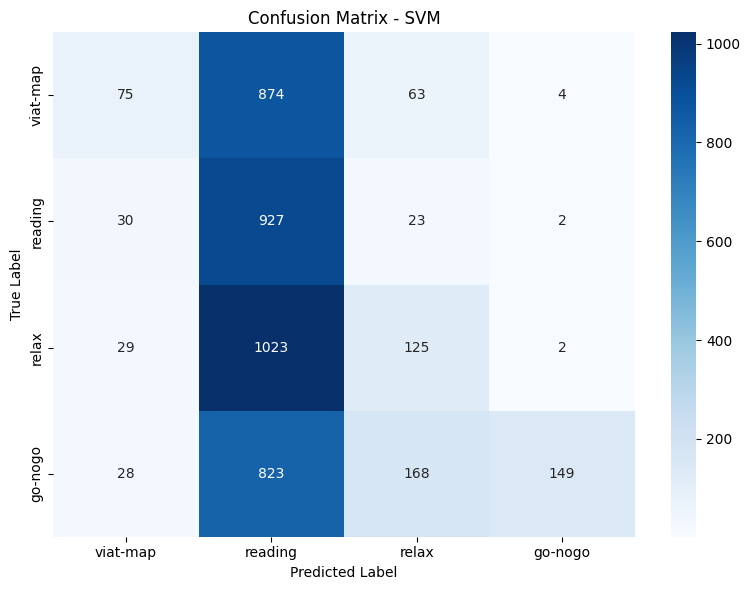

In [55]:
# Daftar nama kelas sesuai label
class_names = ['viat-map', 'reading', 'relax', 'go-nogo']

# Buat confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Visualisasikan
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names)

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix - SVM')
plt.tight_layout()
plt.show()


In [28]:
eeg_bands = {
    'Delta': (0.5, 4),
    'Theta': (4, 8),
    'Alpha': (8, 12),
    'Beta': (12, 30),
    'Gamma': (30, 45)
}


In [29]:
from scipy.signal import welch

def compute_band_powers(signal, fs):
    freqs, psd = welch(signal, fs, nperseg=fs*2)
    band_powers = {}
    for band, (low, high) in eeg_bands.items():
        idx_band = np.logical_and(freqs >= low, freqs <= high)
        band_power = np.trapz(psd[idx_band], freqs[idx_band])
        band_powers[band] = band_power
    return band_powers


In [39]:
def get_sample_bandpowers(X, y, fs, category_map):
    import random
    category_bandpowers = {}

    for label_name, label_id in category_map.items():
        indices = np.where(y == label_id)[0]
        sample_idx = random.choice(indices)
        signal = X[sample_idx]  # 1D array

        bp = compute_band_powers(signal, fs)
        category_bandpowers[label_name] = bp

    return category_bandpowers


d:\Skripsi\eeg-analysis\env\Lib\site-packages\scipy\signal\_spectral_py.py:790: UserWarning: nperseg = 500 is greater than input length  = 128, using nperseg = 128
  freqs, _, Pxy = _spectral_helper(x, y, fs, window, nperseg, noverlap,
C:\Users\Administrator\AppData\Local\Temp\ipykernel_35376\1113632901.py:8: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  band_power = np.trapz(psd[idx_band], freqs[idx_band])


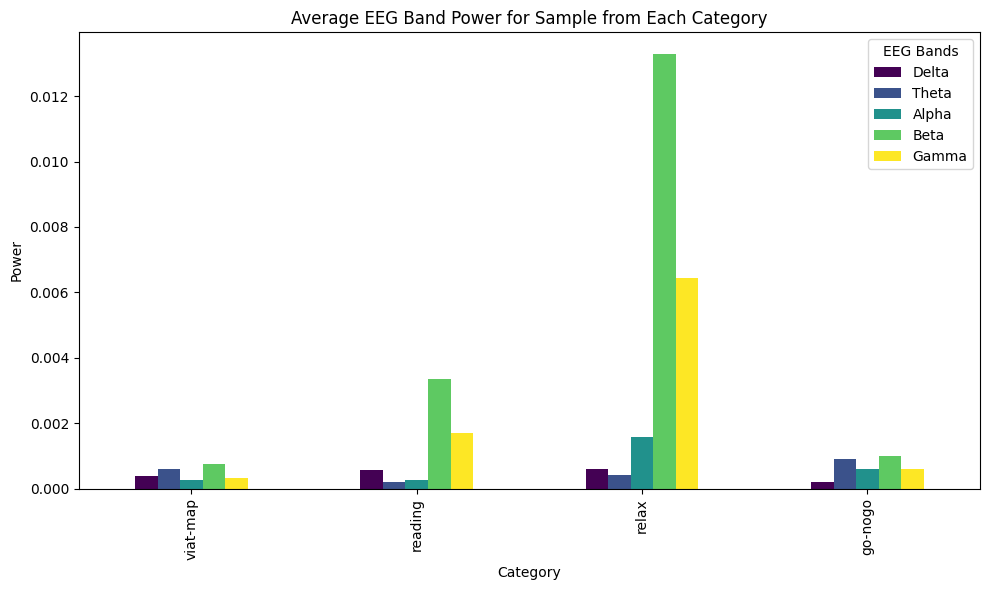

In [42]:
category_map = {
    'viat-map': 0,
    'reading': 1,
    'relax': 2,
    'go-nogo': 3,
}

# Ambil band power 1 sampel per kategori
bandpowers = get_sample_bandpowers(X, y, fs=250, category_map=category_map)

# Plot hasilnya
plot_bandpowers(bandpowers)


In [37]:
def plot_bandpowers(bandpowers):
    df = pd.DataFrame(bandpowers).T
    df.plot(kind='bar', figsize=(10, 6), colormap='viridis')
    plt.title('Average EEG Band Power for Sample from Each Category')
    plt.ylabel('Power')
    plt.xlabel('Category')
    plt.legend(title='EEG Bands')
    plt.tight_layout()
    plt.show()


In [ ]:
# Load data
X, y = load_and_process_data('experiment')

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Model
clf = GaussianNB()
clf.fit(X_train, y_train)

# Evaluasi
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred, target_names=['viat-map', 'reading', 'relax', 'go-nogo']))


In [ ]:
import joblib
joblib.dump(clf, 'svm_model.pkl')
joblib.dump(scaler, 'scaler.pkl')
